In [55]:
import linopy
import pypsa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import cartopy
import cartopy.crs as ccrs

import networkx as nx

from atlite.gis import ExclusionContainer, shape_availability
from rasterio.plot import show
import rasterio as rio

from pathlib import Path

all data provided from TU Berlin can be found here:
https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq

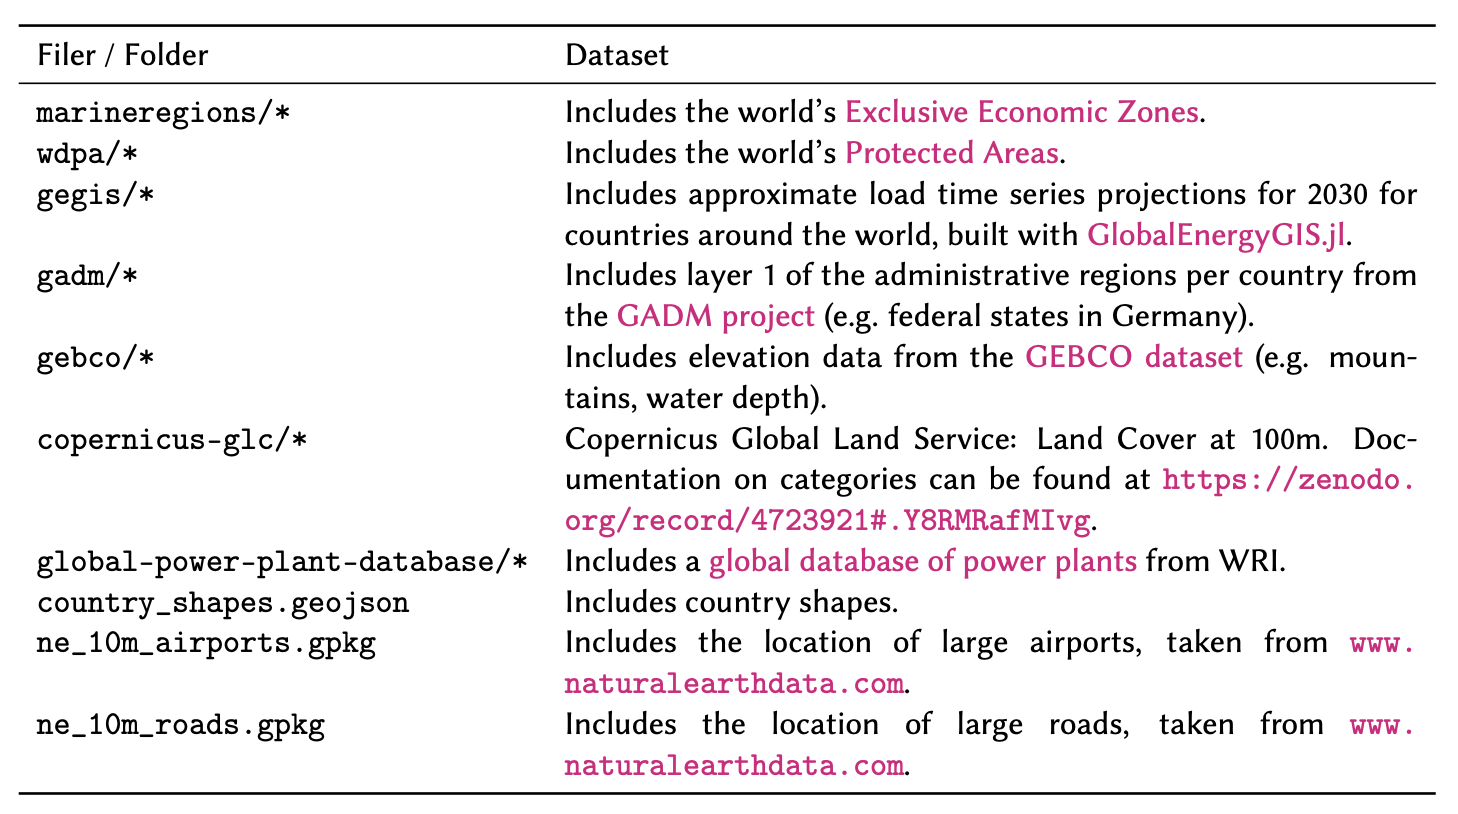

also data on technology and cost assumptions can be found here: https://github.com/PyPSA/technology-data/tree/master/outputs 

global power plant database: https://datasets.wri.org/datasets/global-power-plant-database

In [ ]:
url_countries = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"

url_airports = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg"
url_roads = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg"
url_gadm = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-IRN.gpkg"
url_eez = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fmarineregions%2FWorld_EEZ_v11_20191118_gpkg&files=eez_v11.gpkg"

url_wdpa = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-IRN.tif"

url_gebco = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-IR.nc"

url_load = Path("data") / "load.csv"

In [ ]:
countries = gpd.read_file(url_countries).set_index("name")

# storing shape of the country so it can be used in further steps
shape_ir = countries.to_crs(epsg=3035).loc[["IR"]].geometry

name
IR    MULTIPOLYGON (((7210932.282 2519371.574, 72127...
Name: geometry, dtype: geometry

In [22]:
# preparing the exclusive economice zone of Iran for Wind off-shore analysis
eez = gpd.read_file(url_eez)
eez_ir = eez[eez["SOVEREIGN1"] == "Iran"]
eez_ir

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
162,8469.0,Iranian Exclusive Economic Zone,2126.0,200NM,2126.0,Iran,IRN,Iran,0.0,0.0,...,IRN,None,None,364,NaN,NaN,364.0,NaN,NaN,"MULTIPOLYGON (((56.087 27.10831, 56.08874 27.1..."


In [ ]:
# preparing the data of states of Iran
gadm_ir = gpd.read_file(url_gadm)
gadm_ir["bus"] = gadm_ir.geometry.centroid # to be used as bus for modeling
gadm_ir

/var/folders/h3/z_4l05b96rn0jmfgxq7ty0lw0000gn/T/ipykernel_21379/2769424856.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,GID_0,GID_1,COUNTRY,NAME_1,geometry,bus
0,IRN,IRN.1_1,Iran,Alborz,"MULTIPOLYGON (((51.11609 35.73298, 51.14558 35...",POINT (50.81771 35.94833)
1,IRN,IRN.2_1,Iran,Ardebil,"MULTIPOLYGON (((48.50534 38.02509, 48.48986 38...",POINT (48.04655 38.44612)
2,IRN,IRN.3_1,Iran,Bushehr,"MULTIPOLYGON (((52.67042 27.4607, 52.67042 27....",POINT (51.37902 28.85475)
3,IRN,IRN.4_1,Iran,Chahar Mahall and Bakhtiari,"MULTIPOLYGON (((51.14743 32.18388, 51.15947 32...",POINT (50.64977 31.94483)
4,IRN,IRN.5_1,Iran,East Azarbaijan,"MULTIPOLYGON (((46.38165 36.97453, 46.37059 36...",POINT (46.59085 37.97105)
5,IRN,IRN.6_1,Iran,Esfahan,"MULTIPOLYGON (((51.22968 31.71423, 51.24065 31...",POINT (52.46413 33.17888)
6,IRN,IRN.7_1,Iran,Fars,"MULTIPOLYGON (((52.9134 27.41733, 52.91028 27....",POINT (53.18696 29.29613)
7,IRN,IRN.8_1,Iran,Gilan,"MULTIPOLYGON (((50.01936 36.64008, 49.99538 36...",POINT (49.45636 37.27586)
8,IRN,IRN.9_1,Iran,Golestan,"MULTIPOLYGON (((53.74197 36.80078, 53.76437 36...",POINT (55.06233 37.29607)
9,IRN,IRN.10_1,Iran,Hamadan,"MULTIPOLYGON (((48.52959 34.05629, 48.51778 34...",POINT (48.54946 34.86857)


/Users/morteza/DSESM-venv-312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning:

facecolor will have no effect as it has been defined as "never".



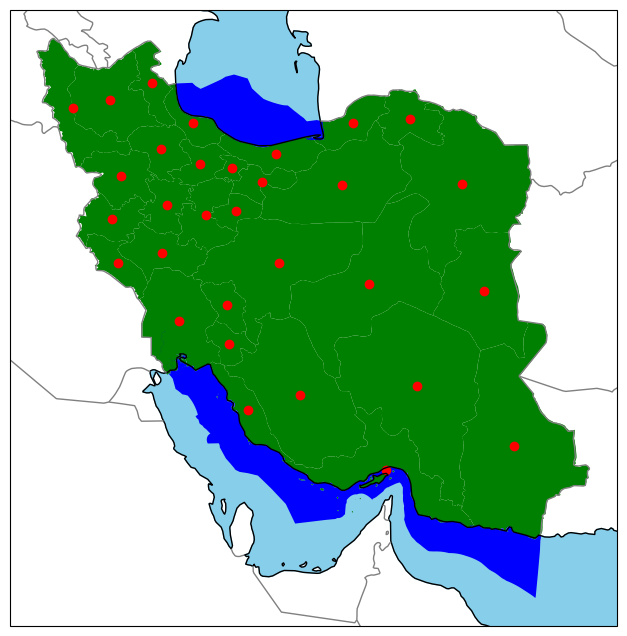

In [31]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

gadm_ir.plot(ax=ax, color="green")
eez_ir.plot(ax=ax, color="blue")
gadm_ir.bus.plot(ax=ax, color="red") # center of each state to be used as bus for modelling

ax.coastlines()

#ax.set_extent([44, 64, 24, 41], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, color="gray")
ax.add_feature(cartopy.feature.OCEAN, color="skyblue")
#ax.add_feature(cartopy.feature.LAND, color="lightgreen")

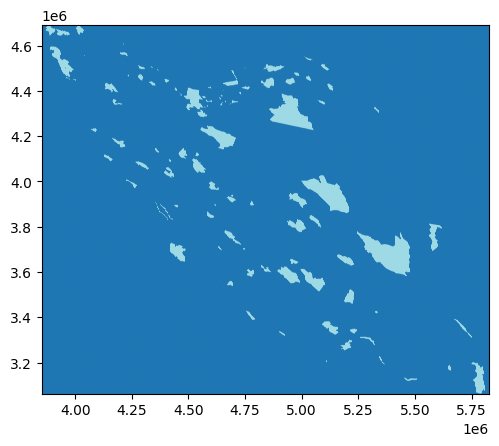

In [ ]:
# world's protected areas
wdpa_ir = rio.open(url_wdpa)
band_wdpa = wdpa_ir.read(1)

show(band_wdpa, transform=wdpa_ir.transform, cmap="tab20")

In [ ]:
# load time series for whole year of 2013
url_load = Path("data") / "load.csv"
load = pd.read_csv(url_load, index_col=0, parse_dates=True)
load_ir = load.IR
load_ir # in MW

time
2013-01-01 00:00:00    44632.674337
2013-01-01 01:00:00    46537.259915
2013-01-01 02:00:00    52027.177061
2013-01-01 03:00:00    54580.901243
2013-01-01 04:00:00    55919.248085
                           ...     
2013-12-31 19:00:00    52289.036304
2013-12-31 20:00:00    45634.742724
2013-12-31 21:00:00    44229.819813
2013-12-31 22:00:00    43648.310049
2013-12-31 23:00:00    43385.474069
Name: IR, Length: 8760, dtype: float64